# Section 1: Data exploration and pre-processing

## Requirements and utilities


In [69]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../source")
import src

## 1. Data Exploration
*a. How many different attribute values do you observe in each feature? (e.g. how many
subreddits are there?) Is there any missing or duplicated data? (Referring to textual
features)*

*b. How does the empirical distribution of the number of characters in each comment look
like? How is the distribution of the number of comments per author? Is the supervised
dataset balanced between male and female? Are there only comments in English? Hint: use
the library langdetect.*

In [2]:
# loading the supervised data
df = pd.read_csv('../data/data_supervised.csv') 
print(f"Dataframe size: {df.shape}")
m = df.shape
# count differents subreddit topics and authors
n_distinc_authors = len(pd.unique(df['author']))
print(f"There are {n_distinc_authors} distinct authors")
# count distinct subreddit (topics)
n_distinct_subreddit = len(pd.unique(df['subreddit']))
print(f"There are {n_distinct_subreddit} distinct subreddit")
# count distinct body (comments)
n_distinct_body = len(pd.unique(df['body']))
print(f"There are {n_distinct_body} distinct body")
# checking missing values
print("\nNull value count for each field")
print(df.isna().sum())
# checking empty stirng
print(f"\nEmpty bodies: ",(df['body'].str.strip() == "").sum())
# checking duplicate values
n_duplicate = df.duplicated().sum()
print(f"Duplicate rows {n_duplicate}")
# count rows with same body.
print(f"Number of identical bodies: ", df['body'].duplicated().sum())



Dataframe size: (296042, 4)
There are 5000 distinct authors
There are 3468 distinct subreddit
There are 289608 distinct body

Null value count for each field
author         0
subreddit      0
created_utc    0
body           0
dtype: int64

Empty bodies:  0
Duplicate rows 7
Number of identical bodies:  6434


In [5]:
# now we think that's useful remove duplicated comments for the same author
before = df.shape[0]
df = df.drop_duplicates(subset=['author', 'body'])
after = df.shape[0]

print(f"Removed {before - after} duplicated comments from the same author.")

Removed 0 duplicated comments from the same author.


### Now we focus about supervised_data exploration

#### Focus on length of the comments

In [6]:
df['char_len'] = df['body'].str.len() # lengths of comments in chars
# plot some statistics
print(f"Char length statistics: ")
print(f"{df['char_len'].describe()}")

Char length statistics: 
count    292550.000000
mean        184.888679
std         328.412255
min           1.000000
25%          42.000000
50%          91.000000
75%         199.000000
max       14271.000000
Name: char_len, dtype: float64


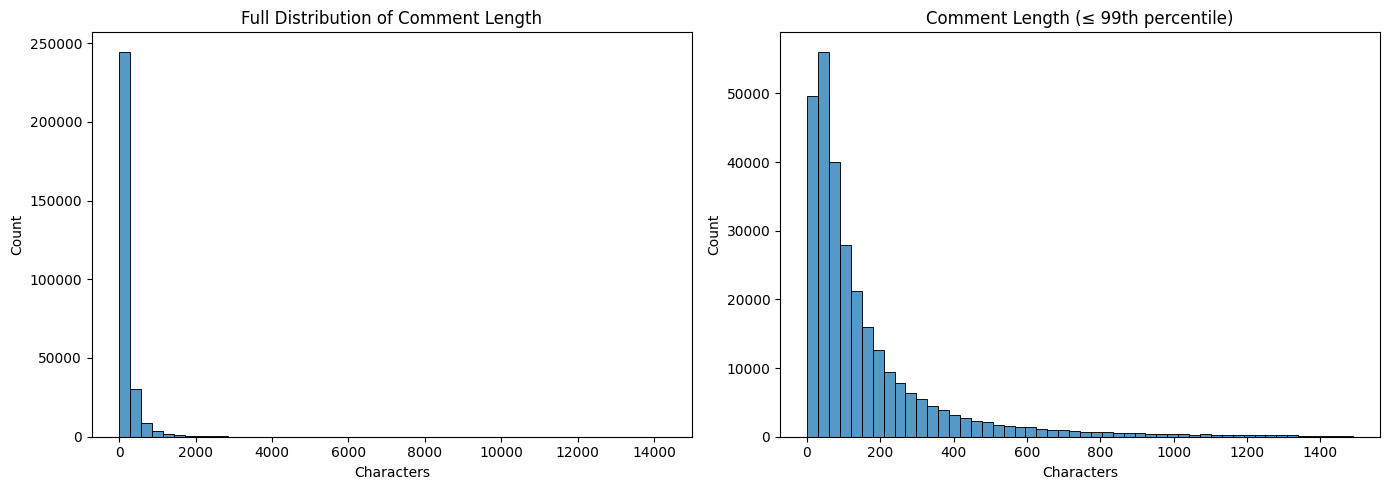

In [7]:
# plot the histograms
cut_99 = df['char_len'][df['char_len'] <= df['char_len'].quantile(0.99)]
# the cut at 99 percentile is useful to cut the tail and have a better visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['char_len'], bins=50, ax=axes[0])
axes[0].set_title("Full Distribution of Comment Length")
axes[0].set_xlabel("Characters")

sns.histplot(cut_99, bins=50, ax=axes[1])
axes[1].set_title("Comment Length (≤ 99th percentile)")
axes[1].set_xlabel("Characters")

plt.tight_layout()
plt.show()



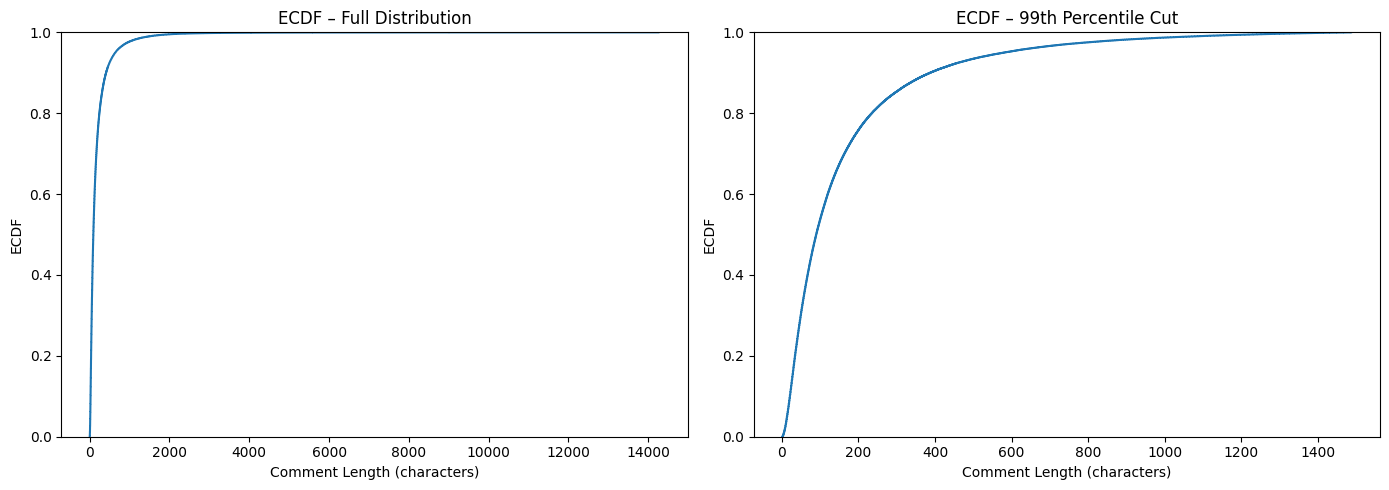

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.ecdfplot(df['char_len'], ax=axes[0])
axes[0].set_title("ECDF – Full Distribution")
axes[0].set_xlabel("Comment Length (characters)")
axes[0].set_ylabel("ECDF")

sns.ecdfplot(cut_99, ax=axes[1])
axes[1].set_title("ECDF – 99th Percentile Cut")
axes[1].set_xlabel("Comment Length (characters)")
axes[1].set_ylabel("ECDF")

plt.tight_layout()
plt.show()


As seen by the statistics, over the 50 % of the comments has a short lenght in terms of characters, usually less than 100 characters.

#### Focus on how many comments a single author has posted

In [9]:
# comments x author
comments_per_author = df['author'].value_counts()
print("Statistics of number of comments per author")
print(comments_per_author.describe())

Statistics of number of comments per author
count     5000.000000
mean        58.510000
std        272.720136
min          1.000000
25%          5.000000
50%         16.000000
75%         54.000000
max      17598.000000
Name: count, dtype: float64


There is a median value of 16 comments per each user, by the way the mean value is around 58 comments, so there are few users that are more active than the others and post thousands of comments

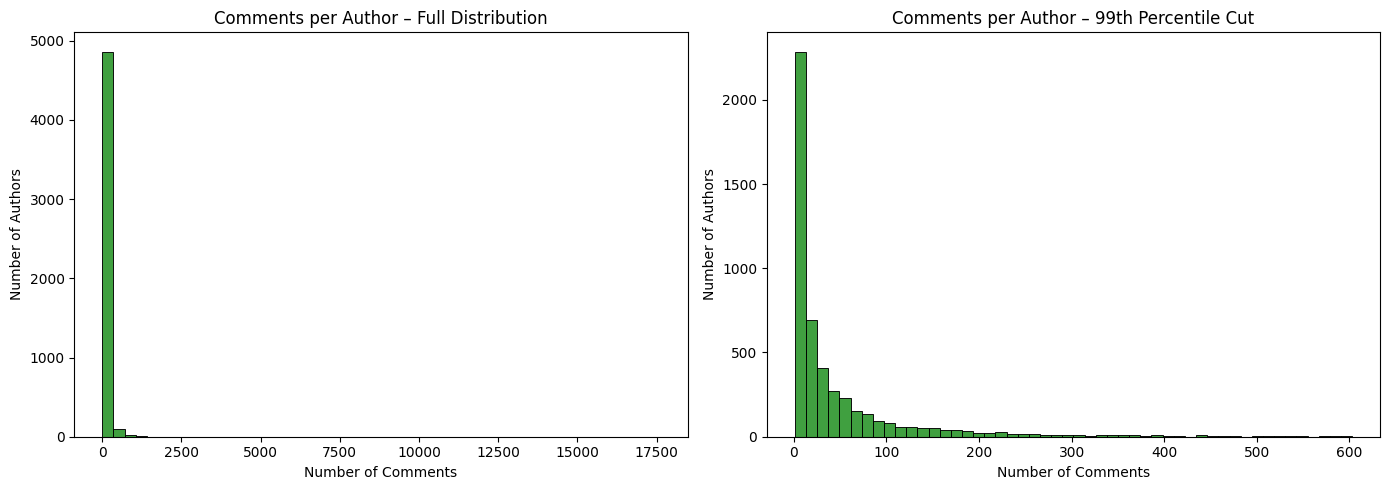

In [31]:
cut_99 = comments_per_author[comments_per_author <= comments_per_author.quantile(0.99)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(comments_per_author, bins=50, ax=axes[0], color='green')
axes[0].set_title("Comments per Author – Full Distribution")
axes[0].set_xlabel("Number of Comments")
axes[0].set_ylabel("Number of Authors")

sns.histplot(cut_99, bins=50, ax=axes[1], color='green')
axes[1].set_title("Comments per Author – 99th Percentile Cut")
axes[1].set_xlabel("Number of Comments")
axes[1].set_ylabel("Number of Authors")

plt.tight_layout()
plt.show()


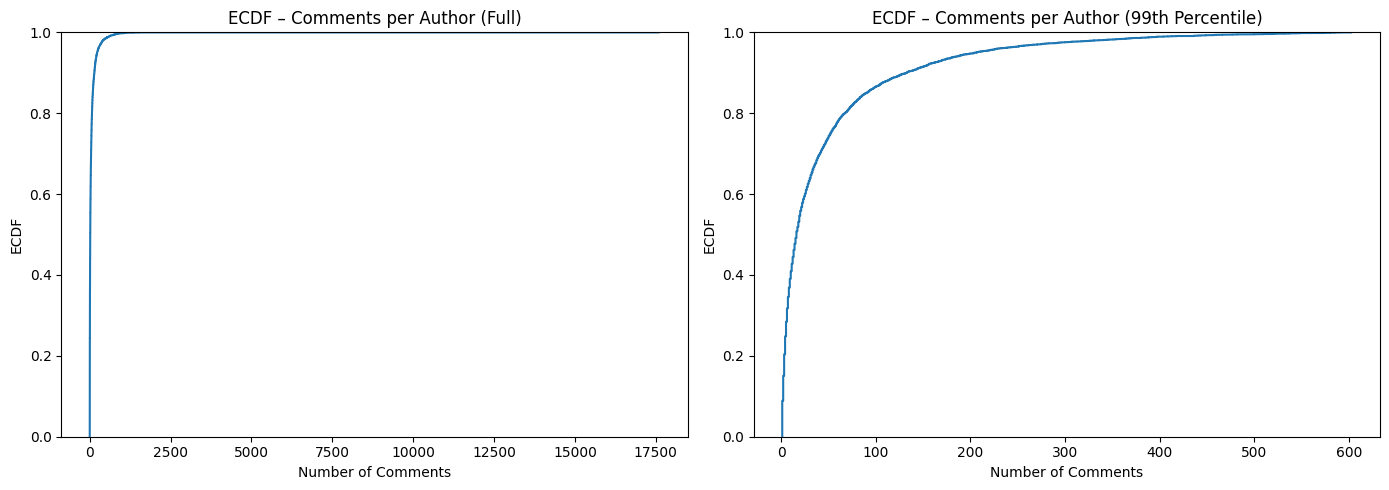

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.ecdfplot(comments_per_author, ax=axes[0])
axes[0].set_title("ECDF – Comments per Author (Full)")
axes[0].set_xlabel("Number of Comments")
axes[0].set_ylabel("ECDF")

sns.ecdfplot(cut_99, ax=axes[1])
axes[1].set_title("ECDF – Comments per Author (99th Percentile)")
axes[1].set_xlabel("Number of Comments")
axes[1].set_ylabel("ECDF")

plt.tight_layout()
plt.show()

#### Contributions of subreddits and how users comments in different topics

In [ ]:
# statistics
print(f"{df['subreddit'].describe()}")

count        292550
unique         3468
top       AskReddit
freq          30751
Name: subreddit, dtype: object


<Axes: xlabel='count', ylabel='subreddit'>

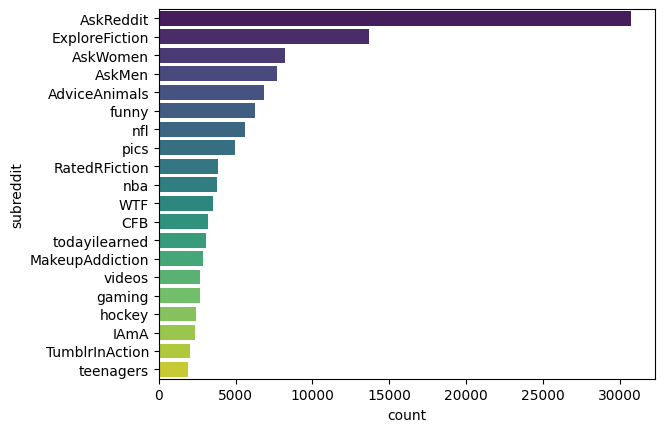

In [18]:
subreddit_counts = df['subreddit'].value_counts()
top_n = 20
top_subreddits = subreddit_counts.head(top_n)
top_df = top_subreddits.reset_index()
top_df.columns = ["subreddit", "count"]

sns.barplot(
    data=top_df,
    x="count",
    y="subreddit",
    hue="subreddit",
    palette="viridis",
    legend=False
)

In [20]:
print(f"{subreddit_counts.head(10)}")
print(f"{subreddit_counts.tail(10)}")

subreddit
AskReddit         30751
ExploreFiction    13669
AskWomen           8237
AskMen             7726
AdviceAnimals      6853
funny              6265
nfl                5637
pics               4940
RatedRFiction      3878
nba                3807
Name: count, dtype: int64
subreddit
IowaCity               1
WikiLeaks              1
bristol                1
treecomics             1
pictureswithpatrick    1
SportingKC             1
auslaw                 1
alcoholism             1
oakland                1
IndianaUniversity      1
Name: count, dtype: int64


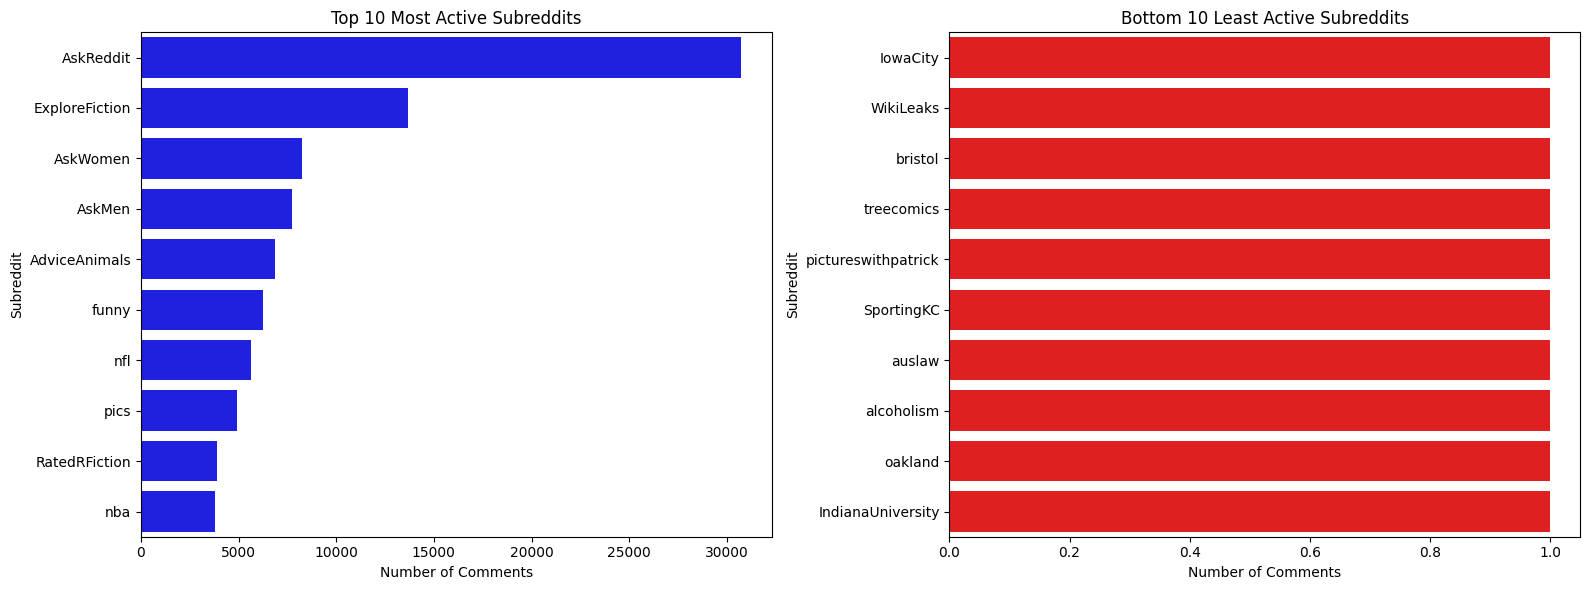

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Top 10
top10 = subreddit_counts.head(10)
sns.barplot(x=top10.values, y=top10.index, ax=axes[0], color="blue")
axes[0].set_title("Top 10 Most Active Subreddits")
axes[0].set_xlabel("Number of Comments")
axes[0].set_ylabel("Subreddit")
# Bottom 10
bottom10 = subreddit_counts.tail(10)
sns.barplot(x=bottom10.values, y=bottom10.index, ax=axes[1], color="red")
axes[1].set_title("Bottom 10 Least Active Subreddits")
axes[1].set_xlabel("Number of Comments")
axes[1].set_ylabel("Subreddit")
plt.tight_layout()
plt.show()

AskReddit is the dominant one, with about 30k comments, then we have other subreddits with lower number of comments and contributions. The tail of the subreddit_counts explains that there are subreddits with 1 comment.

In [24]:
# now let see how athors contribute among subreddit
subreddits_per_author = df.groupby('author')['subreddit'].nunique()
# description
print(f"{subreddits_per_author.describe()}")

count    5000.00000
mean        9.82420
std        11.40132
min         1.00000
25%         3.00000
50%         6.00000
75%        13.00000
max       138.00000
Name: subreddit, dtype: float64


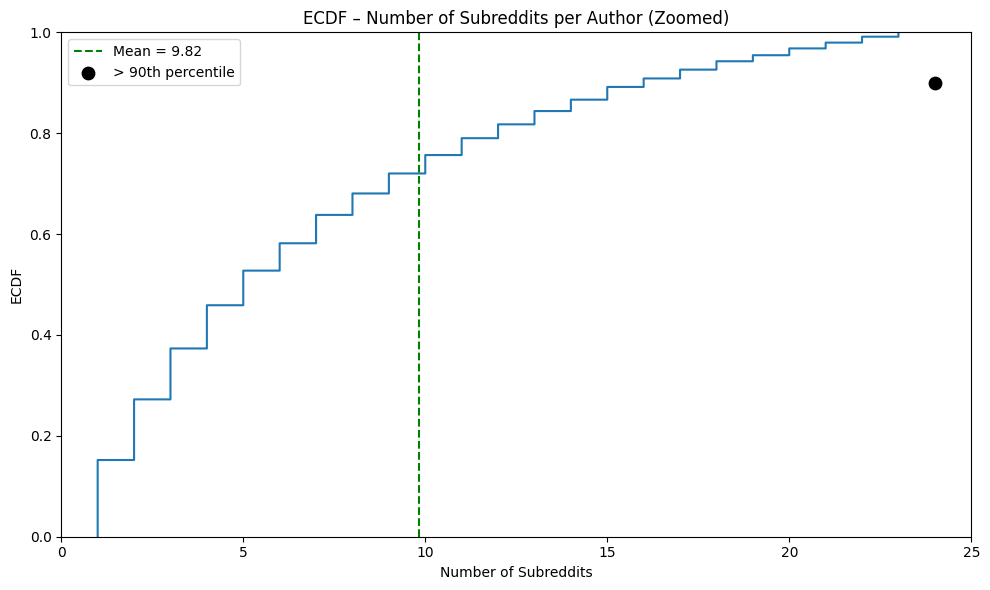

In [29]:
vals = subreddits_per_author
p90 = vals.quantile(0.90)
mean_val = vals.mean()
plt.figure(figsize=(10, 6))
# ECDF 90 percentile
sns.ecdfplot(vals[vals <= p90])
plt.axvline(mean_val, color='green', linestyle='--', label=f"Mean = {mean_val:.2f}")
high_vals = vals[vals > p90]
if len(high_vals) > 0:
    plt.scatter([p90 + 1], [0.90], color='black', s=80, label="> 90th percentile")
plt.title("ECDF – Number of Subreddits per Author (Zoomed)")
plt.xlabel("Number of Subreddits")
plt.ylabel("ECDF")
# Ax X limited plus zoom until at 90° percentile
plt.xlim(0, p90 + 2)
plt.legend()
plt.tight_layout()
plt.show()

The majority of the author contribute in a limited number of subreddits: 50% in 6 or less topics, and a minority of suscribers are involved in tens of subreddits.

#### Reading the target_supervised dataset

In [41]:
target = pd.read_csv('../data/target_supervised.csv')
print(f"{target.columns}")
print(f"{target['author'].count}")

Index(['author', 'gender'], dtype='object')
<bound method Series.count of 0          RedThunder90
1               Lirkmor
2                In0chi
3         ProjectGrudge
4       TehTurtleHermit
             ...       
4995           AdamDe27
4996    sissy_space_yak
4997            lilgump
4998        Hypo_kazoos
4999          Nostalien
Name: author, Length: 5000, dtype: object>


C:\Users\bonio\AppData\Local\Temp\ipykernel_41780\387749310.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


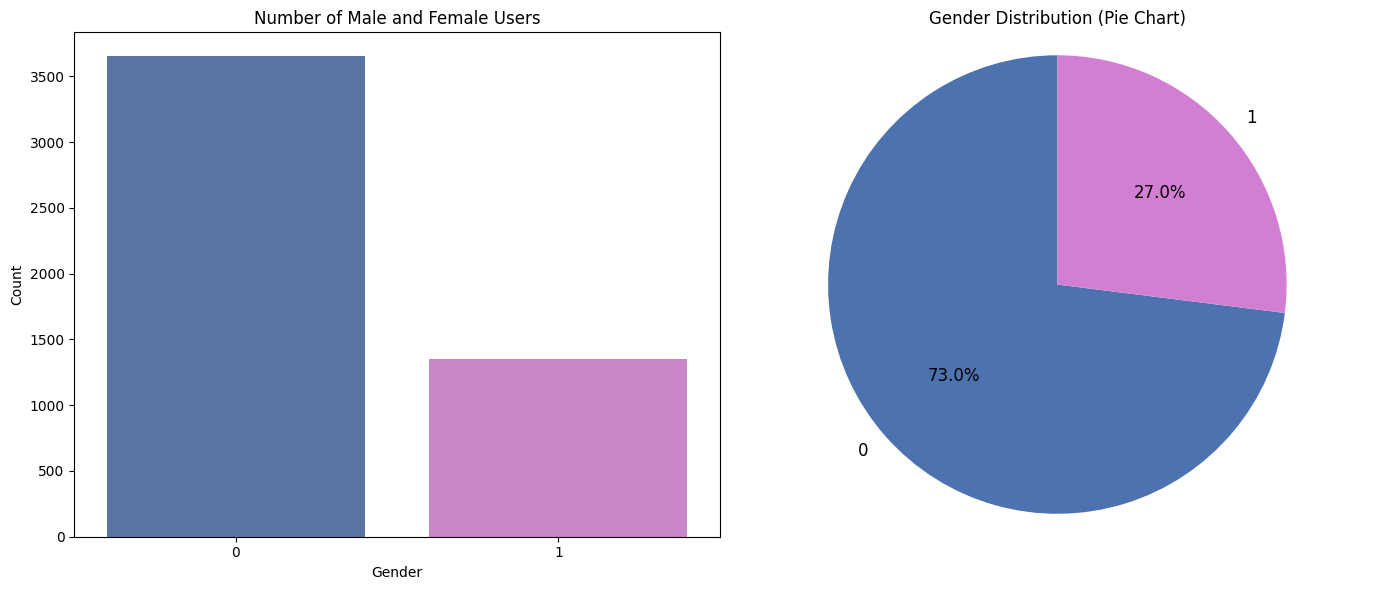

In [43]:
counts = target['gender'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# barplot
sns.barplot(
    x=counts.index,
    y=counts.values,
    ax=axes[0],
    palette= ["#4C72B0", "#D27ED2"]
)
axes[0].set_title("Number of Male and Female Users")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

# pie chart
colors = ["#4C72B0", "#D27ED2"]
axes[1].pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
axes[1].set_title("Gender Distribution (Pie Chart)")
axes[1].axis('equal')
plt.tight_layout()
plt.show()

The division among male and female on this dataset is higly unbalanced with a dominant number of male (3500) and 1550 female.

## 2. Data Cleaning and Text Standardization.

*a. Uniform text formats (e.g., case normalization, Hint: standardize the letters in lower case).If necessary, clean the comment text (e.g. URLs, subreddit refs, …).*

*b. Stop words are not contributing much to our ML tasks, such as "the", "a", since they carry very little information. Take care of these kinds of words.*

*c. Reduce words to their base or root form using Stemming/Lemmatization. This helps in
reducing inflected words to a common base form. (Hint: Consider using libraries like NLTK
or spaCy for tokenization).*


In [47]:
# import needed python libraries
%pip install spacy

%python -m spacy download en_core_web_sm
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import html
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])
from langdetect import detect
import os
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [ ]:
df_supervised   = pd.read_csv("../data/data_supervised.csv")
df_unsupervised = pd.read_csv("../data/data_unsupervised.csv")
df_target       = pd.read_csv("../data/target_supervised.csv")

print(df_supervised.shape, df_unsupervised.shape, df_target.shape)

*Uniform text formats (e.g., case normalization, Hint: standardize the letters in lower case). If necessary, clean the comment text (e.g. URLs, subreddit refs, …).*



In [ ]:
remove_pattern = r'https?://\S+|www\.\S+|r/\w+|u/\w+'

df_supervised['body_normalized'] = (
    df_supervised['body']
    .fillna('')                                     # To handling NaN
    .astype(str)                                    # Ensure string format
    .str.lower()                                    # Case normalization (Punto a.)
    .apply(html.unescape)                           # Decoding HTML (es. &amp; -> &)
    .str.replace(remove_pattern, ' ', regex=True)   # Removing URL, r/, u/
    .str.replace(r'\s+', ' ', regex=True)           # Removing double blank spaces
    .str.strip()                                    # Strip
)

df_unsupervised['body_normalized'] = (
    df_unsupervised['body']
    .fillna('')
    .astype(str)
    .str.lower()
    .apply(html.unescape)
    .str.replace(remove_pattern, ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)


In [ ]:
print(df_supervised[["body", 'body_normalized']].head())

*b. Stop words are not contributing much to our ML tasks, such as "the", "a", since they carry very little information. Take care of these kinds of words.*

*c. Reduce words to their base or root form using Stemming/Lemmatization. This helps in reducing inflected words to a common base form. (Hint: Consider using libraries like NLTK or spaCy for tokenization).*

In [ ]:
def process_text_full(text_series, batch_size=2000):
    clean_texts = []

    total_docs = len(text_series)

    # tqdm show the process bar
    for doc in tqdm(nlp.pipe(text_series, batch_size=batch_size), total=total_docs, desc="Processing"):

        tokens = []
        for token in doc:
            # 1. Filtering Stop Words e punctation (b)
            if not token.is_stop and not token.is_punct and not token.is_space:
                # 2. Take the lemma using spaCy (c)
                tokens.append(token.lemma_)

        clean_texts.append(" ".join(tokens))

    return clean_texts


if os.path.exists("./clean_supervised.csv") and os.path.exists("./clean_supervised.csv"):
    print("File found! Loading...")
    df_unsupervised = pd.read_csv("./clean_unsupervised.csv")
    df_supervised = pd.read_csv("./clean_supervised.csv")
else:
    print("Elaboration of SUPERVISED dataset (smaller)...")
    df_supervised['body_clean'] = process_text_full(df_supervised['body_normalized'].astype(str))
    df_supervised.to_csv("./clean_supervised.csv", index=False)

    print("Elaboration of UNSUPERVISED  dataset (bigger)...")
    df_unsupervised['body_clean'] = process_text_full(df_unsupervised['body_normalized'].astype(str))
    df_unsupervised.to_csv("./clean_unsupervised.csv", index=False)


### Plotting of stuff ###

In [ ]:
# Calcoliamo il numero di token (parole)
df_supervised['n_words_original'] = df_supervised['body'].astype(str).apply(lambda x: len(x.split()))
df_supervised['n_words_normalized'] = df_supervised['body_normalized'].astype(str).apply(lambda x: len(x.split()))
df_supervised['n_words_clean'] = df_supervised['body_clean'].astype(str).apply(lambda x: len(x.split()))


In [ ]:
plt.figure(figsize=(12, 6))

sns.kdeplot(df_supervised['n_words_normalized'], fill=True, label='First Processing (Normalized)', color='salmon', alpha=0.5)
sns.kdeplot(df_supervised['n_words_clean'], fill=True, label='Second Processing (Lemmatized + No Stopwords)', color='skyblue', alpha=0.5)

plt.title('KDE words per comment: before and after')
plt.xlabel('Number of words')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.legend()
plt.show()

print(f"Mean Normalized Words: {df_supervised['n_words_original'].mean():.2f}")
print(f"Mean Clean Words: {df_supervised['n_words_clean'].mean():.2f}")

In [ ]:
def get_top_words(body, n=20):
    all_body = ' '.join(body.fillna(''))
    words = all_body.split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['word', 'count'])

top_normalized = get_top_words(df_supervised['body_normalized'])
top_clean = get_top_words(df_supervised['body_clean'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=top_normalized, x='count', y='word', hue='word', ax=axes[0], palette='Reds_r', legend=False)
axes[0].set_title('Top 20 Words (Normalized)')

sns.barplot(data=top_clean, x='count', y='word', hue='word', ax=axes[1], palette='Blues_r', legend=False)
axes[1].set_title('Top 20 Words (Cleaned & Lemmized)')

plt.tight_layout()
plt.show()


In [ ]:
vocab_normalized = set(' '.join(df_supervised['body_normalized'].astype(str)).split())
vocab_clean = set(' '.join(df_supervised['body_clean'].astype(str)).split())

metrics = pd.DataFrame({
    'Stage': ['Normalized', 'Cleaned'],
    'Unique Words (Vocabulary)': [len(vocab_normalized), len(vocab_clean)]
})

plt.figure(figsize=(6, 5))
sns.barplot(
    data=metrics,
    y='Unique Words (Vocabulary)',
    hue='Stage',
    palette='viridis',
    legend=False
)
plt.title('Vocabulary Dimension Reduction')
for index, row in metrics.iterrows():
    plt.text(
        index,
        row['Unique Words (Vocabulary)'],
        f"{row['Unique Words (Vocabulary)']}",
        color='black',
        ha="center",
        va="bottom"
    )
plt.show()



In [ ]:
from collections import Counter
from tqdm import tqdm

def check_non_alphanumeric(text_series):
    anomalies = Counter()
    text_list = text_series.fillna('').astype(str).tolist()
    for text in text_list:
        for char in text:
            if not char.isalpha() and not char.isspace():
                anomalies[char] += 1
    return anomalies

anomalie_trovate = check_non_alphanumeric(df_supervised['body_clean'])

print("\n--- CHECCKKK!!! ---")
print(f"Found {len(anomalie_trovate)} NON-alphabetic characters")
for char, count in anomalie_trovate.most_common():
    print(f"   Char: [{char}]  -  Compairs: {count}")


## 3 Text Vectorization.

*a. Only for the supervised task (data_supervised.csv): Group and join all comments of the
same author, creating a “new” dataset to be used for the supervised task (Section 2).*

*b: As ML algorithms struggle to handle directly the raw textual data. You are required to
convert the text into numerical representations (vectors) through Bag of Words (BoW).*

*c: Another way to assign a vector representation to a word is to associate the TF-IDF
representation (Term Frequency-Inverse Document Frequency) to each user/comment.
Can you observe and explain the differences between the numerical representations
generated by BoW and TF-IDF?*


*A Wrap up section at the bottom describing which files are created and where by this notebook is at the very end of the notebook. To change the input file instead view the very first cell of the notebook. Originally meant for only the supervised dataset as described by the requirements.*

For problems contact Matteo Sottocornola on Telegram.

### Part 1 of 1.3

*Only for the supervised task (data_supervised.csv): Group and join all comments of the
same author, creating a “new” dataset to be used for the supervised task (Section 2).*

In [ ]:
# TODO capire se aggiungere aggregated subreddit/created_utc

# import as panda dataframe.
import pandas as pd
import numpy as np

df = pd.read_csv("./clean_supervised.csv") #In principio da usare solo su clean_supervised.
print(df.shape)

In [ ]:
#Drop the two unneeded columns inside clean_supervised
#Rename the cleaned body to just body cause I prefer that way.
df = df.drop(columns=['body','body_normalized'])
df = df.rename(columns={'body_clean':'body'})

In [ ]:
print(df.shape)

In [ ]:
#Non sicuro se anche questi andrano tenuti/concatenati come body quindi drop per ora.
df_text_only = df.drop(columns=['created_utc','subreddit'])
print(df_text_only)

#nella parte 2 di Rocco ci sono testi che diventano vuoti (e giusto cosi erano interamente composti da stop words).
#Qui li sto semplicemente togliendo. Da notare che alcuni utenti vanno scartati
#perche non hanno piu nessun commento.
print(df_text_only.shape)
df_text_only = df_text_only.dropna(subset=['body']) #perdiamo un 6000 su 296,000 posts.
print(df_text_only.shape)


In [ ]:
#come richiesto per ogni autore dobbiamo avere una sola riga con tutti i body concatenati.
df_grouped = df_text_only.groupby('author')['body'].apply(" ".join).reset_index()
print(df_grouped)

In [ ]:
#Quick sanity check.
i=4 #select an index, and as such a user.
user = df.iloc[i,0]
print("user: ", user," posted this: ", df.iloc[i, 3])

print(df.groupby("author").size().loc[user] )
#df.groupby("author").count()['author'=df.iloc[0, 0]]

row = df_grouped[df_grouped["author"] == user] #user
#print(row.iloc[0,1]) 
#You should see in the last print somewhere within the text a copy of the previously printed body.

In [ ]:
#Convertiamo ad un numpy  per ragioni di efficenza/memoria.
numpy_grouped = df_grouped[["author","body"]].to_numpy()

### Part 2 of 1.3
*B: As ML algorithms struggle to handle directly the raw textual data. You are required to
convert the text into numerical representations (vectors) through Bag of Words (BoW).*

*Bag of Words (BoW) is a technique widely used to transform textual data into machine-readable format, specifically numerical values, without considering grammar and word order.*

*We will be counting the occurence of every word in the vocabulary we use. Where the word was and it's actual structure is lost. Basically you are adding a new column for each word that is in our dataset and adding the number of times it was used for each row.*

*Note that executing 1.2 to remove stop words first is heavily recomended to reduce the number of words and hence attributes we get with BoW.*

In [ ]:
#useful example of BoW
#https://www.datacamp.com/tutorial/python-bag-of-words-model?dc_referrer=https%3A%2F%2Fwww.google.com%2F

from collections import defaultdict
import string

#df_grouped = df_grouped[:400] #remove after 1.2 available, done to reduce complexity for now.


#Dobbiamo creare un vocabolario di tutte le parole usate nei svariati body.
# Function to preprocess and tokenize
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize: split the text into words
    tokens = text.split()
    return tokens


vocabulary = set()

for sentence in numpy_grouped[:, 1]:
    tokens = preprocess(sentence)
    vocabulary.update(tokens)

vocabulary = sorted(vocabulary)

print(len(vocabulary))


In [ ]:
#Create a dictionary so future lookups are O(1)
word2idx = {w:i for i,w in enumerate(vocabulary)}

def create_bow_vector(sentence):
    vector = [0] * len(word2idx)  # Initialize a vector of zeros
    for word in sentence:
        idx = word2idx.get(word)  # Find the index of the word in the vocabulary using dictionary.
        if idx is not None:
            vector[idx] += 1  # Increment the count at that index
    return vector

#initialize numpy_bow
numpy_bow = np.zeros((numpy_grouped.shape[0], len(vocabulary)), dtype=np.int32)

# Create BoW vector for each author, i.e. for each body in our numpy_grouped.
for i ,raw_text in enumerate(numpy_grouped[:,1]):
    tokens = preprocess(raw_text) #tokenize.
    temp = create_bow_vector(tokens)
    numpy_bow[i, :] = temp

#Lento perche troppe parole nel vocabulary.

In [ ]:
np.set_printoptions(threshold=np.inf)
# most but not all will be zeroes, that's normal.

In [ ]:
#Ci servira scrivere da qualche parte anche autori per ricordarci a chi corrisponde.
authors = numpy_grouped[:, 0]   # shape (n_auth,)

print(authors.shape)
print(numpy_bow.shape)

In [ ]:
#np.savetxt("1.3-bow-authors2.csv", authors, fmt="%s", delimiter=",")
#np.savetxt("1.3-bow_matrix.csv", numpy_bow, fmt="%d", delimiter=",")

np.save("1.3-bow_matrix.npy", numpy_bow)
np.save("1.3-bow-authors.npy", authors)
#poi si legge cosi.
#numpy_bow = np.load("bow_matrix.npy")
#authors = np.load("authors.npy")

### Part 3 of 1.3 - TF-IDF

*Another way to assign a vector representation to a word is to associate the TF-IDF
representation (Term Frequency-Inverse Document Frequency) to each user/comment.
Can you observe and explain the differences between the numerical representations
generated by BoW and TF-IDF?*

*For TF-IDF it is necessary to create the vocabulary of all the distinct words and then for each word performing the following calculation which requires computing these two first...*

![Fig1.png](Fig1.png)


*In practice for every word A and each user we calculate two metrics, one is what percentage of overall users used word A (log of this number). And the other is what percentage of the words used by that specific user correspond to A. The index is then the multiple of these two.*

*It's meant to provide a measure of how important each word is to that text, but corrected to cancel out words that are just common in general and not common to this specific text.*

In [ ]:
#We reuse the vocabulary computed for the previous section so execute that first.
print(len(vocabulary))

In [ ]:
from collections import Counter
import math

# Count in how many documents each word appears
df_counter = Counter()

# Create BoW vector for each author, i.e. for each body in our numpy_grouped.
for raw_text in numpy_grouped[:,1]:
    tokens = preprocess(raw_text) #tokenize.
    unique_words = set(tokens)
    df_counter.update(unique_words)

N = authors.shape[0]            # number of documents

idf = [math.log(N / df_counter.get(word, 1)) for word in vocabulary]

In [ ]:
print(type(idf))
print(len(idf))
print(len(vocabulary))

In [ ]:
#now to compute the second metric TF and directly the TF-IDF
#word2idx from earlier is re used.

def create_TF_IDF_vector(sentence, idf):
    vector = [0] * len(idf)  # If not present in user's comment then TF-IDF is 0.
    
    for word in sentence:
        idx = word2idx.get(word)  # Find the index of the word in the vocabulary
        if idx is not None:
            vector[idx] += 1  # Increment the count at that index
    
    
    for i in range(len(idf)):
        vector[i] = vector[i] / len(sentence)
        vector[i] = vector[i] * idf[i]
    
    return vector

In [ ]:
# Preallocate the full TF-IDF matrix
TFIDF_vectors = np.zeros((numpy_grouped.shape[0], len(idf)), dtype=float)


#TFIDF_vectors = []

# Create TF-IDF vector for each sentence in the processed corpus
for i, raw_text in enumerate(numpy_grouped[:,1]):
    tokens = preprocess(raw_text) #tokenize.
    #TFIDF_vectors.append(create_TF_IDF_vector(tokens,idf))
    temp = create_TF_IDF_vector(tokens, idf)
    TFIDF_vectors[i, :] = temp


In [ ]:
print("Single DF-IDF row")
np.set_printoptions(threshold=np.inf)
#print(TFIDF_vectors[17])

In [ ]:
#Debug - checks
ind = 0
for el in TFIDF_vectors[1]:
    if el != 0.0:
        print(el, ind)
    ind = ind + 1

In [ ]:
#Debug - checks
print(idf[36451]*0.5, idf[79596]*0.5)

In [ ]:
ind = 0
for el in TFIDF_vectors[18]:
    if el != 0.0:
        print(el, ind)
        print("index: ", ind, " TF-IDF: ", el, " for word: ", vocabulary[ind])
    ind = ind + 1

In [ ]:
#np.savetxt("1.3-tf_idf-authors.csv", authors, fmt="%s", delimiter=",")
#np.savetxt("1.3-tf_idf_matrix.csv", TFIDF_vectors, fmt="%d", delimiter=",")

np.save("1.3-tf-idf-matrix.npy", TFIDF_vectors)
np.save("1.3-tf-idf-authors.npy", authors)
#poi si legge cosi.
#numpy_bow = np.load("bow_matrix.npy")
#authors = np.load("authors.npy")

In [ ]:
import csv

with open("1.3-bow-vocabulary.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(vocabulary)
#check saved correctly
#with open("1.3-bow-vocabulary.csv", "r", encoding="utf-8") as f:
#    reader = csv.reader(f)
#    vocabulary2 = next(reader)

In [ ]:
#check saved correctly
#print(vocabulary)
#print(vocabulary2)

## 4 Reduce the complexity of your dataset.
*Threshold-based: BoW and TF-IDF representations use the same large vocabulary, which
can result in a very high-dimensional feature space. This may lead to issues like the curse of
dimensionality or even out-of-memory errors when processing the data. Use the BoW
representation to identify thresholds to reduce the dimensionality of the feature space of
either the BoW itself or the TF-IDF representation.*

*Hint: Consider removing words that are either too common or too rare, as they often carry
less useful information. One approach is to filter out words whose frequencies fall below a
lower quantile (Ql) or above an upper quantile (Qu).*

*Dimensionality Reduction: Try applying PCA to reduce the dimensionality of your features.
Does it work? How many components would you keep and why? Do the components you
obtain with PCA have a physical interpretation?*
*Note: The number of features is very large and both TF-IDF and BoW matrix are sparse.
Suggestion: Do not scale your dataset with StandardScaler. Indeed, subtracting the mean
from each feature will render the sparse matrix a dense one, drastically increasing memory
usage. Try working with the sparse format using scipy.sparse and apply Truncated SVD,
which is designed for sparse data.*


### Threshold-based

In [7]:
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt

In [8]:
bow_matr = np.load('1.3-bow_matrix.npy') 
authors = np.load('1.3-bow-authors.npy', allow_pickle=True) 

# print utilities
print(f"Original dimension: {bow_matr.shape}")
print(f"Type matrix: {type(bow_matr)}")

# converting in sparse matrix
bow_sparse = sparse.csr_matrix(bow_matr)
print(f"Dimensione sparsa: {bow_sparse.shape}")


# compute frequency of words (sum per column)
word_freq = np.array(bow_sparse.sum(axis=0)).flatten()

# some stats
print(f"Min freq: {word_freq.min()}")
print(f"Max freq: {word_freq.max()}")
print(f"Mean freq: {word_freq.mean():.2f}")
print(f"Median freq: {np.median(word_freq):.2f}")

# percentiles
percentiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
print("\nPercentiles distribution:")
for p in percentiles:
    print(f"  {p*100:2.0f}%: {np.quantile(word_freq, p):.2f}")


Original dimension: (4994, 110157)
Type matrix: <class 'numpy.ndarray'>
Dimensione sparsa: (4994, 110157)
Min freq: 1
Max freq: 50091
Mean freq: 37.42
Median freq: 1.00

Percentiles distribution:
   0%: 1.00
   1%: 1.00
   5%: 1.00
  10%: 1.00
  25%: 1.00
  50%: 1.00
  75%: 5.00
  90%: 26.00
  95%: 78.00
  99%: 652.44
  100%: 50091.00


### Visualization

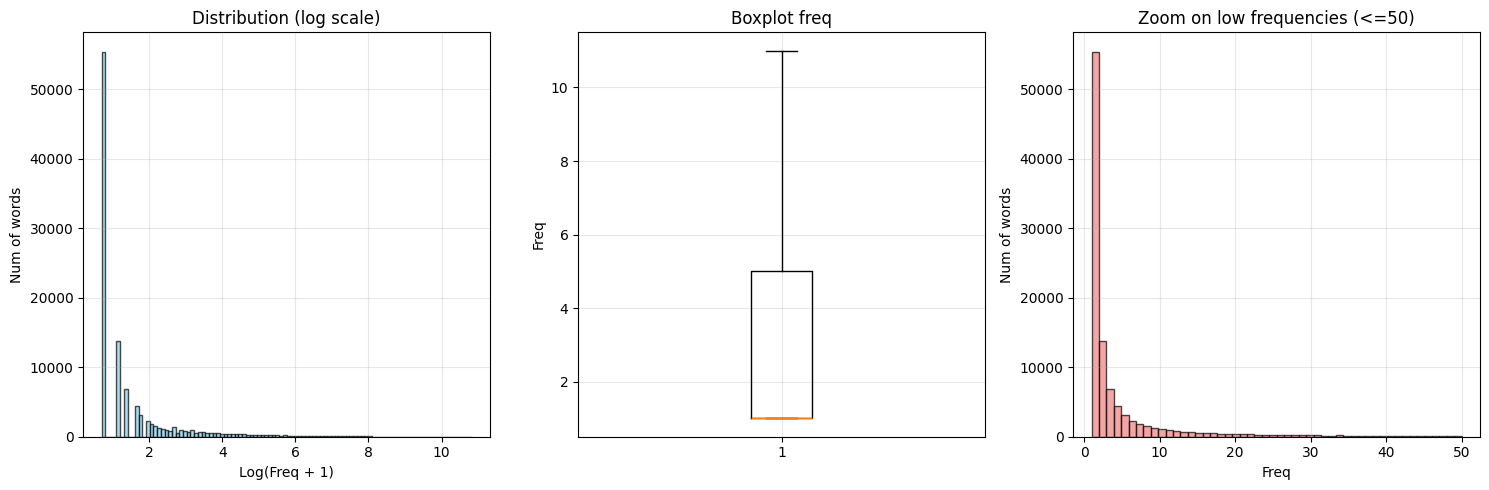

In [9]:
# visualization
plt.figure(figsize=(15, 5))

# Log distr
plt.subplot(1, 3, 1)
plt.hist(np.log1p(word_freq), bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Log(Freq + 1)')
plt.ylabel('Num of words')
plt.title('Distribution (log scale)')
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 3, 2)
plt.boxplot(word_freq, showfliers=False)
plt.ylabel('Freq')
plt.title('Boxplot freq')
plt.grid(True, alpha=0.3)

# Zoom on low freq
plt.subplot(1, 3, 3)
low_freq = word_freq[word_freq <= 50]  # Solo frequenze <= 50 per vedere meglio
plt.hist(low_freq, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Freq')
plt.ylabel('Num of words')
plt.title('Zoom on low frequencies (<=50)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### FIltering based on quantiles

In [10]:
#TODO togliere il Q_lower?

Q_lower = 0.01
Q_upper = 0.99

lower_threshold = np.quantile(word_freq, Q_lower)
upper_threshold = np.quantile(word_freq, Q_upper)

print(f"Quantilies choosen: {Q_lower} - {Q_upper}")
#print(f"Lower threshold (deleting words with freq <= {lower_threshold:.2f})")
print(f"Upper threshold (deleting words with freq >= {upper_threshold:.2f})")

# Apply the filtering
words_to_keep = (word_freq > lower_threshold) & (word_freq < upper_threshold)
#words_to_keep = (word_freq < upper_threshold)
bow_filtered = bow_sparse[:, words_to_keep]

# Stats of filtering
#words_removed_lower = (word_freq <= lower_threshold).sum()
words_removed_upper = (word_freq >= upper_threshold).sum()
words_kept = words_to_keep.sum()

print(f"\nResults:")
print(f"Words before: {len(word_freq)}")
#print(f"Removed rearest words: {words_removed_lower} ({words_removed_lower/len(word_freq)*100:.1f}%)")
print(f"Removed common words: {words_removed_upper} ({words_removed_upper/len(word_freq)*100:.1f}%)")
print(f"Words keeped: {words_kept} ({words_kept/len(word_freq)*100:.1f}%)")
print(f"Dim reducted: {(1 - words_kept/len(word_freq))*100:.1f}%")
print(f"Final BoW matrix: {bow_filtered.shape}")

Quantilies choosen: 0.01 - 0.99
Upper threshold (deleting words with freq >= 652.44)

Results:
Words before: 110157
Removed common words: 1102 (1.0%)
Words keeped: 53656 (48.7%)
Dim reducted: 51.3%
Final BoW matrix: (4994, 53656)


### Showing results

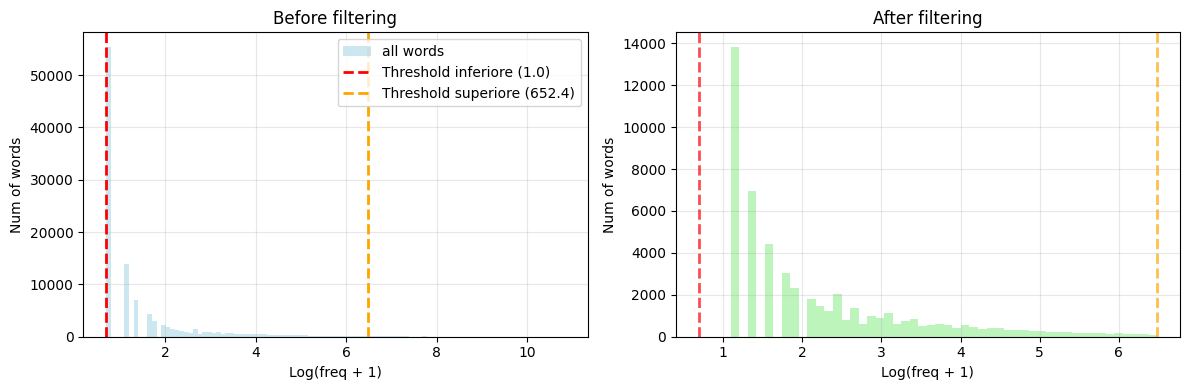

In [11]:
plt.figure(figsize=(12, 4))

# Before filtering
plt.subplot(1, 2, 1)
plt.hist(np.log1p(word_freq), bins=100, alpha=0.6, color='lightblue', label='all words')
plt.axvline(np.log1p(lower_threshold), color='red', linestyle='--', linewidth=2, 
            label=f'Threshold inferiore ({lower_threshold:.1f})')
plt.axvline(np.log1p(upper_threshold), color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold superiore ({upper_threshold:.1f})')
plt.xlabel("Log(freq + 1)")
plt.ylabel("Num of words")
plt.title("Before filtering")
plt.legend()
plt.grid(True, alpha=0.3)

# After filtering
plt.subplot(1, 2, 2)
word_freq_filtered = word_freq[words_to_keep]
plt.hist(np.log1p(word_freq_filtered), bins=50, alpha=0.6, color='lightgreen')
plt.axvline(np.log1p(lower_threshold), color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.axvline(np.log1p(upper_threshold), color='orange', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel("Log(freq + 1)")
plt.ylabel("Num of words")
plt.title("After filtering")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

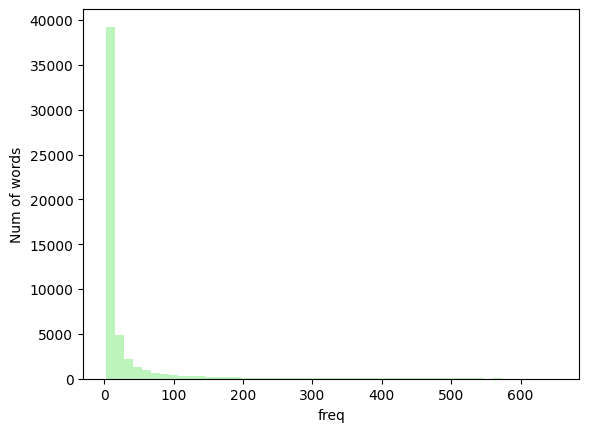

In [12]:
#TODO vogliamo aggiungere questo histograma senza log per il dopo?
#TODO da notare che e giusto lasciare quello in scala log per il confronto sopra.
plt.hist(word_freq_filtered, bins=50, alpha=0.6, color='lightgreen')
plt.xlabel("freq")
plt.ylabel("Num of words")
plt.show()

### Saving results

In [ ]:
# saving results
sparse.save_npz('1.4-bow_filtered_quantile.npz', bow_filtered)
np.save('1.4-words_kept_indices.npy', words_to_keep) #TODO questo si puo sopprimere secondo me. A che ci serve ricordarci che parola corrisponde a cosa?

print(f"Files saved:")
print(f"1.4-bow_filtered_quantile.npz - Matrice BoW filtered")
print(f"1.4-words_kept_indices.npy - index words kept")

tfidf_matrix = np.load('1.3-tf-idf-matrix.npy')
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)
tfidf_filtered = tfidf_sparse[:, words_to_keep]
sparse.save_npz('1.4-tfidf_filtered_quantile.npz', tfidf_filtered)
print(f"1.4-tfidf_filtered_quantile.npz - Matrix TF-IDF filtered")
print(f"Dimension filtered TF-IDF: {tfidf_filtered.shape}")

print(f"Dataset: {bow_sparse.shape[1]} features")
print(f"Dataset filtered: {bow_filtered.shape[1]} features") 
print(f"Final reduction: {(1 - bow_filtered.shape[1]/bow_sparse.shape[1])*100:.1f}%")

## Appling the Truncated Singular Value Decomposition

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [ ]:
#TODO lo so che dopo finiamo con proprio pochi attributi ma sicuro che
#non va applicato al dataset gia filtrato per quantili?
# load data
bow_matrix = np.load('1.3-bow_matrix.npy') 
bow_sparse = sparse.csr_matrix(bow_matrix)
print(f"BoW dimension: {bow_sparse.shape}")

tfidf_matrix = np.load('1.3-tf-idf-matrix.npy')
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)
print(f"TF-IDF dimension: {tfidf_sparse.shape}")
has_tfidf = True

In [ ]:
#TODO sicuro che serve salvarli?
# using sparse matrix
sparse.save_npz("bow_sparse.npz", bow_sparse)
sparse.save_npz("tfidf_sparse.npz", tfidf_sparse)

In [ ]:
bow_sparse1 = sparse.load_npz("bow_sparse.npz")
print("BoW dimensions:", bow_sparse.shape)

tfidf_sparse1 = sparse.load_npz("tfidf_sparse.npz")
print("TF-IDF dimensions:", tfidf_sparse.shape)

In [ ]:
# k components keeped 
k = 100

# truncated svd on matrix to reducing the complexity
svd= TruncatedSVD(n_components=k, random_state=43)

# normalization of vectors
normalizer = Normalizer(copy =False)

# pipeline: svd and then normalization
lsa = make_pipeline(svd, normalizer)

# fit transform on BoW sparse matrix 
X_svd = lsa.fit_transform(bow_sparse1)

print(f"New shape after Truncated SVD: {X_svd.shape}")




In [ ]:
print("Explained variance ratio:", svd.explained_variance_ratio_.sum())

In [ ]:
#TODO credo che manca qualcosa, volevi provare con diversi k e fare il plot?

# visualization of variance curve
plt.figure(figsize=(10, 6))
plt.plot(n_components_options, explained_variances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance curve - Truncated SVD')
plt.grid(True, alpha=0.3)

In [ ]:
# Guide lines per 8'% - 90% of explained variance
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% of variance')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% of variance')
plt.legend()
plt.show()

In [ ]:
# appling the truncated SVD

# choosing the number of components based of variance analysis
n_components_final = 1000  

print(f"Truncated SVD with {n_components_final} components...")

# For BoW
svd_bow = TruncatedSVD(n_components=n_components_final, random_state=42)
bow_svd = svd_bow.fit_transform(bow_sparse)
print(f"BoW after SVD: {bow_svd.shape}")

# For TF-IDF
svd_tfidf = TruncatedSVD(n_components=n_components_final, random_state=42)
tfidf_svd = svd_tfidf.fit_transform(tfidf_sparse)
print(f"TF-IDF after SVD: {tfidf_svd.shape}")

In [ ]:
# svd analysisi
print("First 10 components BoW - explained variance:")
for i, var in enumerate(svd_bow.explained_variance_ratio_[:10]):
    print(f"  Componente {i+1}: {var:.4f}")

# Total explained variance
total_variance_bow = svd_bow.explained_variance_ratio_.sum()
print(f"\ntotal explained variance BoW: {total_variance_bow:.3f}")

# Most important features
def print_top_features(svd_model, feature_names, n_features=10, n_components=3):
    """Stampa le feature più importanti per le prime componenti"""
    components = svd_model.components_
    for i in range(n_components):
        print(f"\nComponente {i+1} - Top features:")
        # Ottieni gli indici delle feature con peso assoluto più alto
        top_indices = np.argsort(np.abs(components[i]))[-n_features:][::-1]
        for idx in top_indices:
            # Nota: qui non abbiamo i nomi delle feature reali
            print(f"  Feature {idx}: peso {components[i][idx]:.4f}")

# Nota: Non abbiamo i nomi delle feature, quindi mostriamo solo gli indici
print("\nTop features per prime 3 componenti BoW:")
print("(Nota: senza nomi feature reali, mostro solo indici)")
for i in range(3):
    top_indices = np.argsort(np.abs(svd_bow.components_[i]))[-10:][::-1]
    print(f"Componente {i+1}: features {top_indices}")

#TODO la list vocabulary ce l'hai ancora ed e nello stesso ordine.
for i in range(3):
    top_indices = np.argsort(np.abs(svd_bow.components_[i]))[-10:][::-1]
    print(f"Componente {i+1}: features", end=" ")
    for idx in top_indices:
        print(vocabulary[idx], end=" ")
    print("")

In [ ]:
# Saving matrix
np.save('1.4-bow_svd_reduced.npy', bow_svd)
np.save('1.4-tfidf_svd_reduced.npy', tfidf_svd)

# Salva i modelli SVD #TODO sicuro che vogliamo salvare i modelli abbiamo di piu in piu file in sta cartella.
import joblib
joblib.dump(svd_bow, '1.4-svd_bow_model.pkl')
joblib.dump(svd_tfidf, '1.4-svd_tfidf_model.pkl')

print(f"Original: {bow_sparse.shape} -> reducted: {bow_svd.shape}")
print(f"Reduction: {(1 - bow_svd.shape[1]/bow_sparse.shape[1])*100:.1f}%")
print(f"Preserved variance: {total_variance_bow*100:.1f}%")

In [ ]:
# differences between truncated svd and threshold
try:
    bow_filtered = sparse.load_npz('1.4-bow_filtered_quantile.npz')
    print("CONFRONTO FINALE:")
    print(f"Threshold-based: {bow_filtered.shape} (mantiene parole reali)")
    print(f"Truncated SVD:    {bow_svd.shape} (componenti latenti)")
    print("\nVantaggi Threshold-based:")
    print("  • Features interpretabili (parole reali)")
    print("  • Mantiene semantica originale")
    print("\nVantaggi Truncated SVD:")
    print("  • Riduzione più aggressiva")
    print("  • Cattura correlazioni tra features")
    print("  • Meno sensibile al rumore")
    
except:
    print("Dati threshold-based non trovati per confronto")